##Code & Report: Monocular Depth Estimation, Semantic Segmentation & 3D Tracking Pipeline

###Core Objectives:

#### - Accepts a single RGB image input.

#### - Estimates a per-pixel depth map using a deep learning model.

#### - Segments the image into semantic regions.

#### - Performs instance-based pseudo object tracking in 3D using depth cues.

#### - Visualizes outputs: original image, depth map, segmentation mask, overlay, and 3D visualization.

#### - Optionally exports the 3D object tracking information for downstream use.

##Design Strengths
**Modular:** Each step is self-contained and reusable.

**Lightweight:** All inference is real-time capable for modest scenes.

**Compatible with vision + robotics:** Tracking data is suitable for later export to ROS, 3D maps, or planners.

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

##Component Breakdown
###Depth Estimation with MiDaS
**What:** Loads Intel’s MiDaS DPT-Hybrid model from torch.hub.

**Why:** MiDaS is a state-of-the-art model for monocular depth estimation trained on diverse scenes.

**How:** It infers depth from RGB images without requiring stereo or sensor depth.

In [ ]:
# Load MiDaS
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
midas.eval()

In [ ]:
# Load MiDaS
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
midas.eval()

midas_transforms.dpt_transform used to apply appropriate pre-processing for the model (resizing, normalization, etc.).

In [4]:
# Load MiDaS transform
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform if hasattr(midas_transforms, 'dpt_transform') else midas_transforms.default_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


##Semantic Segmentation using DeepLabV3
**What:** Loads a pretrained segmentation model from torchvision.

**Why:** DeepLabV3 with ResNet-101 backbone is accurate and pretrained on COCO/PASCAL datasets.

**How:** Outputs pixel-wise class predictions. extracted the most likely label using: (e.g. output.argmax(0))

In [5]:
# Load DeepLabV3 for segmentation
deeplab = deeplabv3_resnet101(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 105MB/s]


In [7]:
# Depth Estimation
def estimate_depth(img_rgb):
    input_tensor = transform(img_rgb)
    if isinstance(input_tensor, dict):
        input_tensor = input_tensor["image"]
    input_batch = input_tensor  # Already batched

    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    return prediction.cpu().numpy()

In [8]:
# Semantic Segmentation
def get_segmentation_mask(img_rgb):
    preprocess = T.Compose([
        T.ToPILImage(),
        T.Resize(520),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img_rgb).unsqueeze(0)
    with torch.no_grad():
        output = deeplab(input_tensor)['out'][0]
    return output.argmax(0).byte().cpu().numpy()

###Segmentation Overlay
**What:** Color-code the segmentation results and blend them with the input.

**Why:** To visualize semantic regions in context with the original image.

**How:** Used cv2.addWeighted() to overlay the segmentation with transparency.

In [9]:
# Visualization
def overlay_segmentation(img_rgb, mask, alpha=0.6):
    num_classes = mask.max() + 1
    colors = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)

    color_mask = colors[mask]
    color_mask_resized = cv2.resize(color_mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    blended = cv2.addWeighted(img_rgb, 1 - alpha, color_mask_resized, alpha, 0)

    return color_mask_resized, blended

###Pseudo 3D Object Tracking via Depth & Segmentation
**What:** Extracted instance masks from the segmentation map using connected components.

**Why:** To simulate tracking and uniquely identify multiple instances of the same class (e.g., people, cars).

**How:**
*   cv2.connectedComponents() → separates instances within one class.
*   cv2.findContours() + cv2.boundingRect() → identifies object boundaries.
*   The depth map provides the Z-coordinate at the object’s center.

*   Return tracking_data: bounding box, label, ID, and estimated 3D location.

In [10]:
def pseudo_3d_object_tracking(img_rgb, mask, depth_map, min_area=1000):
    # Get unique classes
    unique_labels = np.unique(mask)

    output = img_rgb.copy()
    h, w = img_rgb.shape[:2]

    tracking_data = []

    for label in unique_labels:
        if label == 0:  # Skip background
            continue

        # Mask only this class
        class_mask = (mask == label).astype(np.uint8)

        # Find connected components (objects)
        num_labels, labels_im = cv2.connectedComponents(class_mask)

        for obj_id in range(1, num_labels):
            obj_mask = (labels_im == obj_id).astype(np.uint8)
            contours, _ = cv2.findContours(obj_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if not contours:
                continue

            # Find bounding box
            x, y, w_box, h_box = cv2.boundingRect(contours[0])

            if w_box * h_box < min_area:
                continue

            # Center pixel location
            cx = x + w_box // 2
            cy = y + h_box // 2

            # Depth at center
            if 0 <= cy < depth_map.shape[0] and 0 <= cx < depth_map.shape[1]:
                z = depth_map[cy, cx]
            else:
                z = 0

            # Annotate image
            cv2.rectangle(output, (x, y), (x + w_box, y + h_box), (0, 255, 0), 2)
            cv2.putText(output, f"ID:{label}_{obj_id}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            cv2.putText(output, f"Z={z:.2f}", (x, y + h_box + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

            tracking_data.append({
                "label": int(label),
                "object_id": int(obj_id),
                "bbox": (x, y, w_box, h_box),
                "center_3d": (cx, cy, float(z))
            })

    return output, tracking_data

###Processing for output
*   Generates 5 visualizations using matplotlib: input, depth, segmentation, overlay, and tracking.

*   Returns structured tracking information (tracking_info) for further use.

In [11]:
def process_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    depth_map = estimate_depth(img_rgb)
    mask = get_segmentation_mask(img_rgb)
    color_mask, overlay = overlay_segmentation(img_rgb, mask)
    tracked_img, tracking_data = pseudo_3d_object_tracking(img_rgb, mask, depth_map)

    # Display all outputs
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 5, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.title("Depth Map")
    plt.imshow(depth_map, cmap="inferno")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.title("Segmentation")
    plt.imshow(color_mask)
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.title("Segmentation Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.title("3D Object Tracking")
    plt.imshow(tracked_img)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return tracking_data  # Optional: useful for logs, downstream logic

###Pipeline Entry Point
**What:** The single function call to run all pipeline stages on a provided image path.

**Why:** Encapsulates and automates processing without requiring manual step-by-step calls.

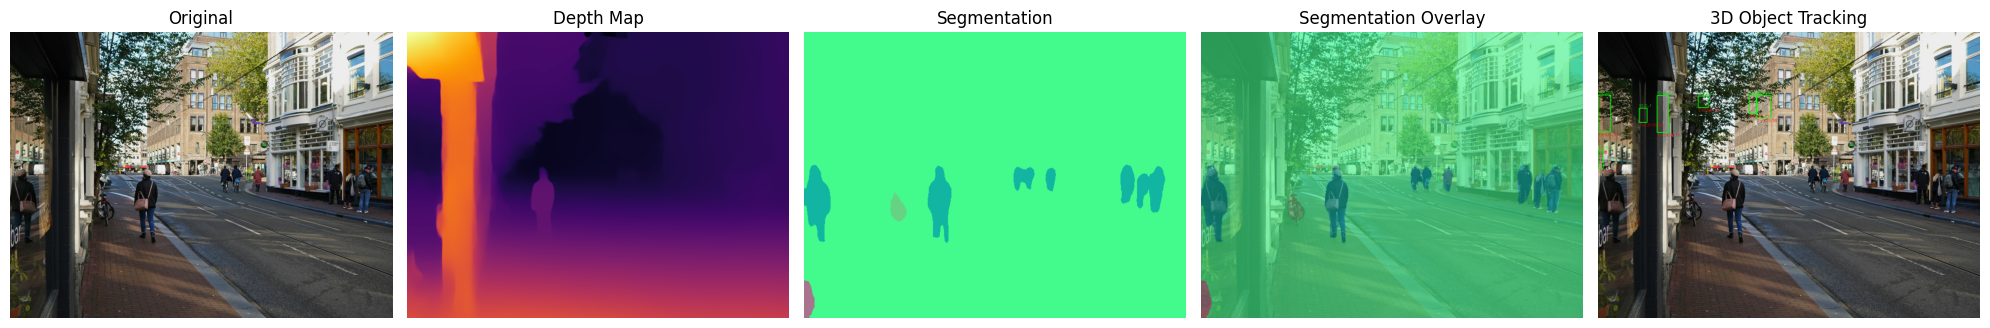

In [14]:
tracking_info = process_image("/content/2.jpg")

In [15]:
tracking_info

[{'label': 2,
  'object_id': 1,
  'bbox': (156, 292, 30, 54),
  'center_3d': (171, 319, 2510.6787109375)},
 {'label': 15,
  'object_id': 1,
  'bbox': (0, 242, 48, 140),
  'center_3d': (24, 312, 431.4072265625)},
 {'label': 15,
  'object_id': 2,
  'bbox': (574, 242, 26, 71),
  'center_3d': (587, 277, 526.7208251953125)},
 {'label': 15,
  'object_id': 3,
  'bbox': (224, 244, 43, 140),
  'center_3d': (245, 314, 2438.107666015625)},
 {'label': 15,
  'object_id': 4,
  'bbox': (603, 244, 52, 85),
  'center_3d': (629, 286, 225.98379516601562)},
 {'label': 15,
  'object_id': 5,
  'bbox': (380, 246, 38, 44),
  'center_3d': (399, 268, 589.485595703125)},
 {'label': 16,
  'object_id': 1,
  'bbox': (0, 452, 19, 68),
  'center_3d': (9, 486, 311.11883544921875)}]

###3D Visualization in Colab
**What:** Uses mpl_toolkits.mplot3d to visualize the 3D object center positions.

**Why:** Gives an intuitive sense of spatial layout in depth from a single RGB image.

**How:**

*   xs, ys, zs are extracted from center_3d tracking points.

*   A text label is drawn above each object.

*   Color map applied to highlight depth (Z axis) distribution.

/tmp/ipython-input-18-509215185.py:32: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


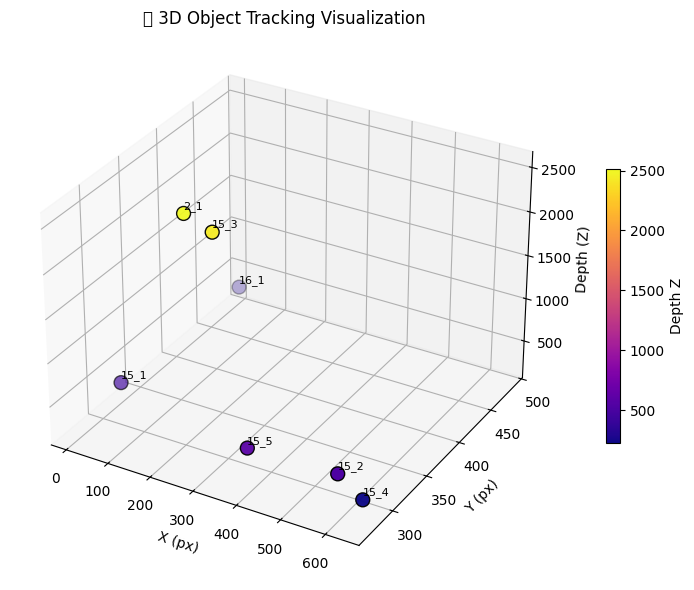

In [18]:
# Example tracking data (your actual list)
# tracking_data = [
#     {'label': 2, 'object_id': 1, 'bbox': (156, 292, 30, 54), 'center_3d': (171, 319, 2510.6787109375)},
#     {'label': 15, 'object_id': 1, 'bbox': (0, 242, 48, 140), 'center_3d': (24, 312, 431.4072265625)},
#     {'label': 15, 'object_id': 2, 'bbox': (574, 242, 26, 71), 'center_3d': (587, 277, 526.7208251953125)},
#     {'label': 15, 'object_id': 3, 'bbox': (224, 244, 43, 140), 'center_3d': (245, 314, 2438.107666015625)},
#     {'label': 15, 'object_id': 4, 'bbox': (603, 244, 52, 85), 'center_3d': (629, 286, 225.98379516601562)},
#     {'label': 15, 'object_id': 5, 'bbox': (380, 246, 38, 44), 'center_3d': (399, 268, 589.485595703125)},
#     {'label': 16, 'object_id': 1, 'bbox': (0, 452, 19, 68), 'center_3d': (9, 486, 311.11883544921875)}
# ]

# Extract coordinates and labels
xs = [obj["center_3d"][0] for obj in tracking_data]
ys = [obj["center_3d"][1] for obj in tracking_data]
zs = [obj["center_3d"][2] for obj in tracking_data]
labels = [f'{obj["label"]}_{obj["object_id"]}' for obj in tracking_data]

# Plotting in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(xs, ys, zs, c=zs, cmap='plasma', s=100, edgecolors='k')
for x, y, z, label in zip(xs, ys, zs, labels):
    ax.text(x, y, z + 50, label, fontsize=8)

ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")
ax.set_zlabel("Depth (Z)")
ax.set_title("3D Object Tracking Visualization")
plt.colorbar(sc, shrink=0.5, label="Depth Z")

plt.tight_layout()
plt.show()

##Opportunities to Extend

**Temporal tracking:** Feed multiple frames and add motion-aware trackers like SORT/DeepSORT.

**3D point cloud:** Fuse full-frame depth and semantic masks to build dense point clouds.

**Sensor fusion:** Overlay 2D LiDAR scans and project them into the same image/depth space.

**ROS integration:** Publish tracking_info into a ROS topic for real-time robot use (e.g., in RViz).